In [1]:
import json

import pandas as pd

from math import pi
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.cluster import KMeans


In [2]:

def run_cluster(data, num_clusters=5):
    # create kmeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)

    # find centers and labels
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # DataFrame of centroids
    centroids_df = pd.DataFrame(centers, columns=data.columns).T

    # print items in clusters
    clusters = {}
    for i in range(len(labels)):
        clusters[players[i]] = labels[i]

    for i in range(len(centers)):
        out = [k for k,v in clusters.items() if v==i]

        print('-'*30)
        print(f'cluster index: {i}')
        for item in out:
            print(item)
        print('\n')

#     centroids_df.to_csv('final_clusters.csv')
    return clusters, centroids_df


In [3]:
data = pd.read_csv('Data/nba_data_player.csv')
players = data.player.to_list()


Here we drop columns we don't want to use in k-means. We dropped mostly total statistics 
in order to limit the degree to which our clusters were grouped by minutes played, as all total statistics are inherently correlated with minutes played, as the more minutes someone plays the more total statistics they accumulate. We also removed all columns that were strings, as those would not be suitable for k-means. 

In [4]:
# nba_data = nba_data.set_index('rank')
nba_data = data.drop(['Unnamed: 0', 'player', 'pos', 'team_id', 'age', 'mp', 'fg', 'fga','fg3',
 'fg3a','fg2',
 'fg2a','ft',
 'fta','orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',], axis=1)


In [5]:
num_clusters = 8
clusters, centroids_df = run_cluster(nba_data,  num_clusters)


------------------------------
cluster index: 0
Bam Adebayo
Marvin Bagley
Aron Baynes
Khem Birch
Bismack Biyombo
Ed Davis
Cheick Diallo
Gorgui Dieng
Cristiano Felicio
Montrezl Harrell
Willy Hernangomez
Richaun Holmes
T.J. Leaf
Alex Len
Meyers Leonard
Kevon Looney
Larry Nance
Joakim Noah
Nerlens Noel
Kyle O'Quinn
Jahlil Okafor
Zaza Pachulia
Mason Plumlee
Jakob Poetl
Dwight Powell
Ivan Rabb
Mitchell Robinson
Domantas Sabonis
Daniel Theis
Ekpe Udoh
Ante Zizic
Tyson Chandler
Kenneth Faried
JaMychal Green
Enes Kanter
Boban Marjanovic
Greg Monroe
Jonas Valanciunas
Ivica Zubac


------------------------------
cluster index: 1
Alex Abrines
Jaylen Adams
Grayson Allen
Kadeem Allen
Justin Anderson
Carmelo Anthony
Dwayne Bacon
Mo Bamba
Keita Bates-Diop
Jerryd Bayless
Michael Beasley
Jaron Blossomgame
Jonah Bolden
Isaiah Briscoe
Ryan Broekhoff
Dillon Brooks
MarShon Brooks
Lorenzo Brown
Troy Brown
Deonte Burton
Bruno Caboclo
Jose Calderon
Jevon Carter
Alex Caruso
Omri Casspi
Gary Clark
Allen Crabbe


In [6]:
player_df = data[['player', 'team_id']]

player_cluster_df = pd.DataFrame([clusters]).T.reset_index()
player_cluster_df = player_cluster_df.rename(columns={'index':'player', 0:'cluster'})

player_type_df = player_df.merge(player_cluster_df, on='player')
player_type_df


,player,team_id,cluster
0,Alex Abrines,OKC,1
1,Jaylen Adams,ATL,1
2,Steven Adams,OKC,4
3,Bam Adebayo,MIA,0
4,LaMarcus Aldridge,SAS,4
...,...,...,...
419,Garrett Temple,LAC,5
420,Jonas Valanciunas,MEM,0
421,Christian Wood,NOP,1
422,Delon Wright,MEM,3


In [13]:
headers = ['Solid Bench Bigs', 'Fringe NBA Players', 'Stars', 'Bench Shooters',
          'Quality Starting Bigs', 'Solid Starting Shooters', 'Solid Low Usg Bench', 'OK Players w/ Injuries']

teams_only_df = player_type_df.loc[player_type_df.team_id != 'TOT'].groupby(['team_id', 'cluster']).count()
max_cluster_size = max([max(teams_only_df.xs(i, level='cluster').player) for i in range(num_clusters)])


In [8]:
# number of players in each cluster
cluster_counts = player_type_df.groupby(['cluster'])['player'].count()

# calculate the number of players per cluster in the average team
avg_values = list(cluster_counts/30)
avg_values += avg_values[:1]

# list of angles for polar axis
angles = [n / float(num_clusters) * 2 * pi for n in range(num_clusters)]
angles += angles[:1]


with open('Data/team_colors.json', 'r') as f:
    team_colors = json.load(f)

def plot_cluster_count(headers, input_values, title='test', fill_color='k', edge_color='k'):
    values = input_values.copy()
    values += values[:1]

    # add plot and figure properties
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, polar=True)
    ax.set_facecolor('#d3d3d3')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # set tick parameters
    plt.xticks(angles[:-1], headers)
    plt.yticks([y for y in range(max_cluster_size+1)])
    ax.set_rlabel_position(0)

    ax.set_ylim([0, max_cluster_size])

    ax.tick_params(axis='x', pad=25)
    ax.tick_params(axis='y', colors='#000000', labelsize=14)

    # plot average team overlay
    ax.plot(angles, avg_values, color='#fcfcfc', linewidth=3.5)
    ax.fill(angles, avg_values, facecolor='#eeeeee', alpha=0.5)
    
    # plot and fill area
    ax.plot(angles, values, color=edge_color, linewidth=3.5)
    ax.fill(angles, values, facecolor=fill_color, alpha=0.5)

    ax.set_title(title, y=1)
    plt.show()


def plot_team(team_abbr):
    # filter data for team
    team_cluster_df = player_type_df.loc[player_type_df.team_id == team_abbr]

    # counts the number of players per cluster
    cluster_group = team_cluster_df.groupby(['cluster']).count()['player']
    cluster_count = {f'cluster {x}': 0 for x in range(8)}
    for i in range(len(cluster_group)):
        cluster_count[f'cluster {cluster_group.index[i]}'] = cluster_group.values[i]

    # get team colors
    colors = [item for item in team_colors[team_abbr.upper()].values()][1:]
    team = team_colors[team_abbr.upper()]['team']

    # plots radar chart
    plot_cluster_count(headers, list(cluster_count.values()), f'player dist for {team}', colors[0], colors[1])


In [9]:
def plot_stats(ax, headers, values, title, edge_color='k', face_color='k'):
    values += values[:1]

    angles = [n / float(len(headers)) * 2 * pi for n in range(len(headers))]
    angles += angles[:1]

    ax.set_facecolor('#d3d3d3')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # set tick parameters
    ax.set_xticklabels(headers)
    ax.set_rlabel_position(0)

    ax.set_ylim([0, 30])

    ax.tick_params(axis='x', pad=25)
    ax.tick_params(axis='y', colors='#000000', labelsize=14)

    # plot and fill area
    ax.plot(angles, values, color=edge_color, linewidth=3.5)
    ax.fill(angles, values, facecolor=face_color, alpha=0.5)

    ax.set_title(title, y=1)


For the player cluster radar charts, we dropped down to 9 basic statistics to visualize the difference between the player's outputs in each cluster. 81 data points was not easy to absorb visually, so we needed to cut down to show the significance. We chose 5 of the basic box score statistics that are looked at from game to game, and 4 advanced statistics to show the difference between box score statistics versus the impact those statistics have on the game.

*We also multiplied 'vorp' by 5 in order for it to be visible on the charts

In [10]:
stats = ['trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'pts_per_g', 'per',
        'usg_pct', 'ws', 'vorp']

cluster_stats = centroids_df.loc[stats]

cluster_stats.loc[['vorp']] = cluster_stats.loc[['vorp']]*5


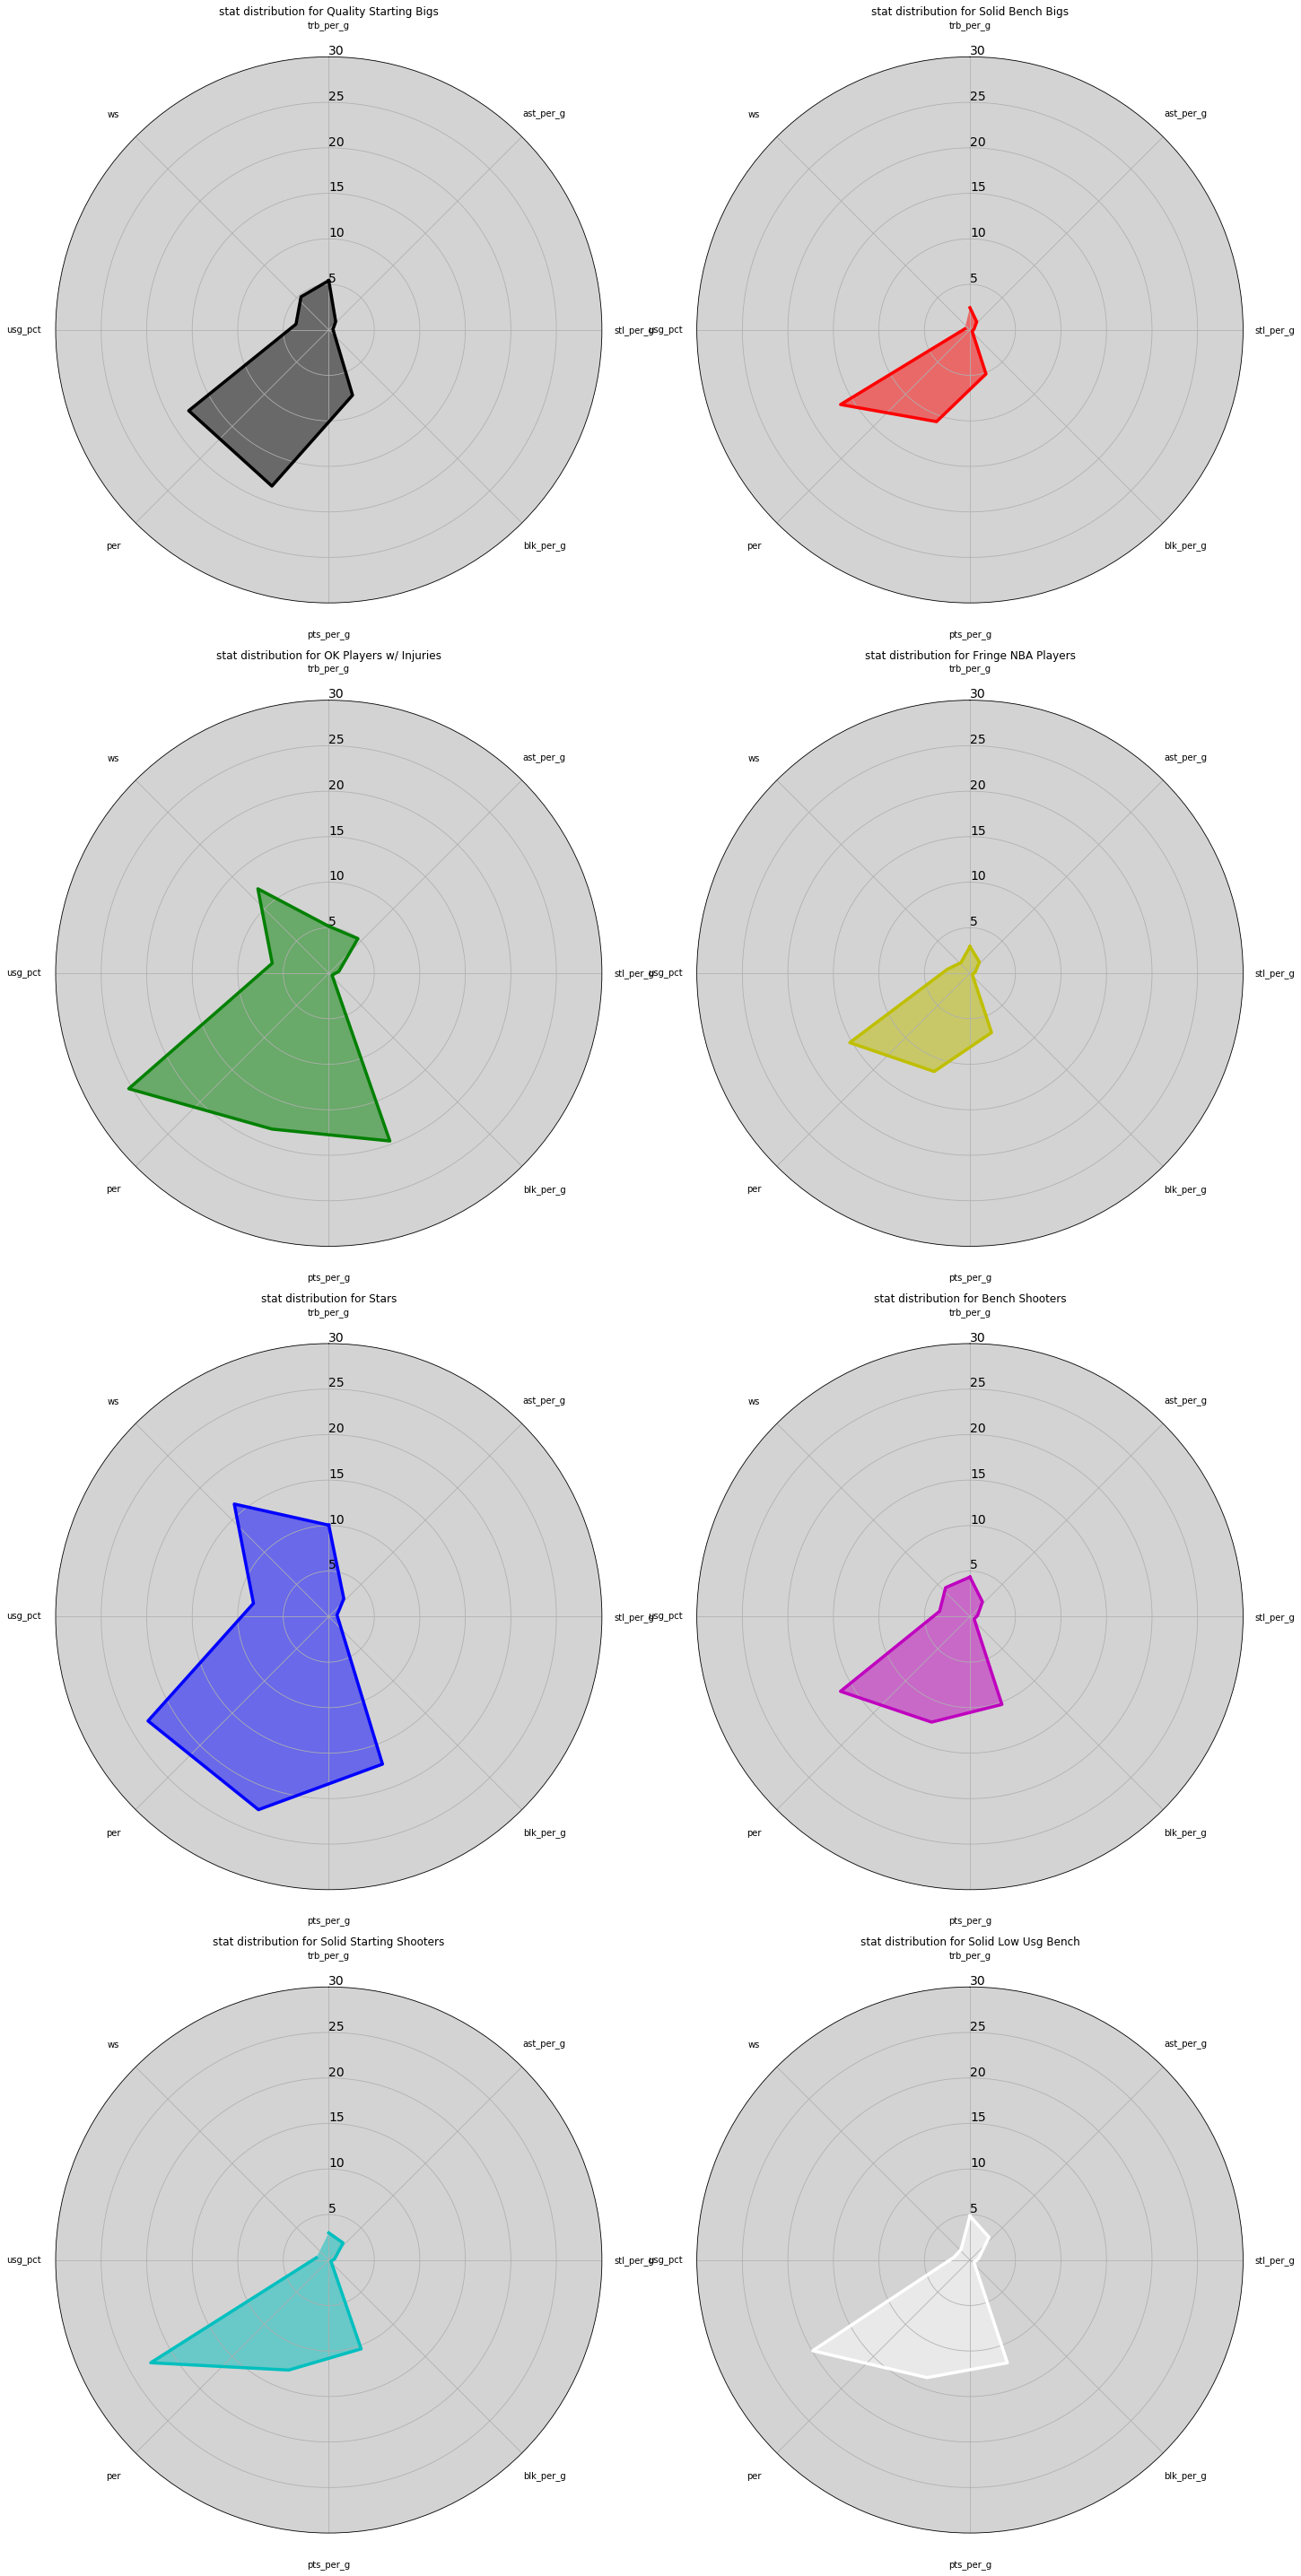

In [11]:
f = plt.figure(figsize=(20, 40))
ax0 = f.add_subplot(421, polar=True)
ax1 = f.add_subplot(422, polar=True)
ax2 = f.add_subplot(423, polar=True)
ax3 = f.add_subplot(424, polar=True)
ax4 = f.add_subplot(425, polar=True)
ax5 = f.add_subplot(426, polar=True)
ax6 = f.add_subplot(427, polar=True)
ax7 = f.add_subplot(428, polar=True)

plot_stats(ax0, stats, list(cluster_stats[0]), 'stat distribution for Solid Bench Bigs', 'k', 'k')
plot_stats(ax1, stats, list(cluster_stats[1]), 'stat distribution for Fringe NBA Players', 'r', 'r')
plot_stats(ax2, stats, list(cluster_stats[2]), 'stat distribution for Stars', 'g', 'g')
plot_stats(ax3, stats, list(cluster_stats[3]), 'stat distribution for Bench Shooters', 'y', 'y')
plot_stats(ax4, stats, list(cluster_stats[4]), 'stat distribution for Quality Starting Bigs', 'b', 'b')
plot_stats(ax5, stats, list(cluster_stats[5]), 'stat distribution for Solid Starting Shooters', 'm', 'm')
plot_stats(ax6, stats, list(cluster_stats[6]), 'stat distribution for Solid Low Usg Bench', 'c', 'c')
plot_stats(ax7, stats, list(cluster_stats[7]), 'stat distribution for OK Players w/ Injuries', 'w', 'w')

f.tight_layout()

plt.show()


Dropdown(index=9, options=('ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND',…

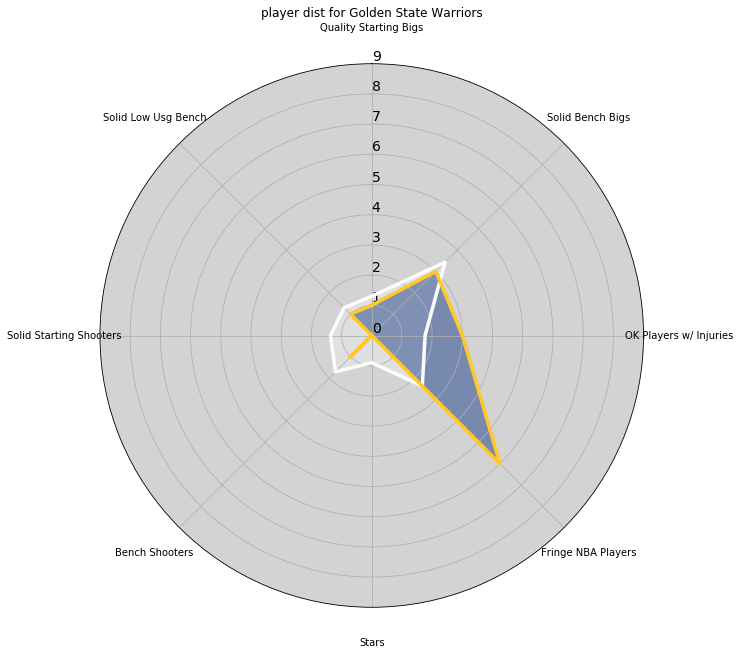

In [12]:
team_list = list(player_df.team_id.unique())
team_list.sort()

team_dropdown = widgets.Dropdown(
    options=team_list,
    value=team_list[0],
    disabled=False
)

display(team_dropdown)

def on_change(change):
    clear_output()
    display(team_dropdown)
    team_abbr = team_dropdown.value
    if change['name'] == 'value':
        plot_team(team_abbr)

team_dropdown.observe(on_change, type='change', names='value')
